# M044_2024_12_04_09_30

Session: M044_2024_12_04_09_30

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../..")

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pyaldata as pyal

from tools.dsp.preprocessing import preprocess
from tools.decoding import decodeTools as decode

import tools.viz.rasters as rt
from tools.params import Params
from tools.viz.dimensionality import plot_VAF
from tools.dataTools import get_data_array
from tools.viz.rasters import plot_heatmap_raster

from tools.dimensionality.participation import participation_ratio, pca_pr
from tools.params import colors
from tools.dimensionality.cca import canoncorr
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score




In [2]:
# TODO: add example data to the repo and run on that
data_dir = "/data/bnd-data/raw/M044/M044_2024_12_04_09_30"
fname0 = os.path.join(data_dir, "M044_2024_12_04_09_30_pyaldata_0.mat")
fname1 = os.path.join(data_dir, "M044_2024_12_04_09_30_pyaldata_1.mat")

In [3]:
df0 = pyal.mat2dataframe(fname0, shift_idx_fields=True)
df1 = pyal.mat2dataframe(fname1, shift_idx_fields=True)
df = pd.concat([df0, df1], ignore_index=True)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_imec0_KSLabel could not be converted to int.
field values_Sol_direction could not be converted to int.
field idx_Sol_direction could not be converted to int.
field values_Sol_duration could not be converted to int.
field idx_Sol_duration could not be converted to int.
array field all_imec0_KSLabel could not be converted to int.


In [4]:
df.head()

,animal,session,trial_id,trial_name,trial_length,bin_size,idx_trial_start,idx_trial_end,idx_CPI,values_before_camera_trigger,...,idx_Sol_direction,values_Sol_duration,idx_Sol_duration,idx_sol_on,idx_earthquake_duration,idx_session_timer,all_imec0_chan_best,all_imec0_unit_guide,all_imec0_KSLabel,all_imec0_spikes
0,M044,M044_2024_12_04_09_30,0,free,60001,0.01,-1,59999,[],1.0,...,[],[],[],[],[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 1], [0, 2], [1, 1], [1, 2], [1, 3], [1, 4...","[good, good, good, mua, good, good, good, good...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,M044,M044_2024_12_04_09_30,1,intertrial,101,0.01,59999,60099,[],[],...,99,50,99,[],[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 1], [0, 2], [1, 1], [1, 2], [1, 3], [1, 4...","[good, good, good, mua, good, good, good, good...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,M044,M044_2024_12_04_09_30,2,trial,401,0.01,60099,60499,[],[],...,-1,50,-1,199,[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 1], [0, 2], [1, 1], [1, 2], [1, 3], [1, 4...","[good, good, good, mua, good, good, good, good...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,M044,M044_2024_12_04_09_30,3,intertrial,101,0.01,60499,60599,[],[],...,99,100,99,[],[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 1], [0, 2], [1, 1], [1, 2], [1, 3], [1, 4...","[good, good, good, mua, good, good, good, good...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,M044,M044_2024_12_04_09_30,4,trial,401,0.01,60599,60999,[],[],...,-1,100,-1,199,[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 1], [0, 2], [1, 1], [1, 2], [1, 3], [1, 4...","[good, good, good, mua, good, good, good, good...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Preprocessing from utils

In [27]:
df_ = preprocess(df, only_trials=False)
areas = ["M1", "Dls"]
df_["M1_rates"] = [df_["all_imec0_rates"][i][:,300:] for i in range(len(df_))]
df_["Dls_rates"] = [df_["all_imec0_rates"][i][:,0:300] for i in range(len(df_))]

/home/me24/.cache/pypoetry/virtualenvs/earthquake-analysis-Z8riI-lB-py3.12/src/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_imec0_spikes ephys data shape is (NxT): (470, 20000)


## Plotting

In [ ]:
df_ = pyal.select_trials(df_, "idx_trial_end > 30365")  # Remove first 5 minutes because the switch was off

In [19]:
df_.head()

,animal,session,trial_id,trial_name,trial_length,bin_size,idx_trial_start,idx_trial_end,idx_CPI,values_before_camera_trigger,...,idx_session_timer,all_imec0_chan_best,all_imec0_unit_guide,all_imec0_KSLabel,all_imec0_spikes,all_imec0_rates,sol_level_id,sol_contra_ipsi,M1_rates,Dls_rates
0,M044,M044_2024_12_04_09_30,0,free,60001,0.03,-1,19999,[],1.0,...,[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [5, 5], [6, 1], [8, 1...","[good, good, good, mua, good, good, good, good...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[12.953449, 10.21812, 0.0, 0.0, 0.0, 0.0, 0.0...",NaN,NaN,"[[0.91412437, 0.0, 13.161868, 0.0, 0.0, 64.864...","[[12.953449, 10.21812, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,M044,M044_2024_12_04_09_30,1,intertrial,101,0.03,19999,20033,[],[],...,[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [5, 5], [6, 1], [8, 1...","[good, good, good, mua, good, good, good, good...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[[9.000157, 0.91841716, 0.0, 0.0, 0.0, 12.9494...",NaN,NaN,"[[0.0, 0.043432135, 0.0, 0.0, 0.0, 20.365671, ...","[[9.000157, 0.91841716, 0.0, 0.0, 0.0, 12.9494..."
2,M044,M044_2024_12_04_09_30,2,trial,401,0.03,20033,20166,[],[],...,[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [5, 5], [6, 1], [8, 1...","[good, good, good, mua, good, good, good, good...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 2.798774, 0.0, 2.798774,...",0.0,0.0,"[[0.00031967516, 0.003973114, 0.0, 0.0, 0.0, 3...","[[0.0, 0.0, 0.0, 0.0, 2.798774, 0.0, 2.798774,..."
3,M044,M044_2024_12_04_09_30,3,intertrial,101,0.03,20166,20199,[],[],...,[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [5, 5], [6, 1], [8, 1...","[good, good, good, mua, good, good, good, good...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[10.21812, 0.0, 0.0, 0.0, 0.00031967516, 0.00...",NaN,NaN,"[[0.034771092, 0.0, 0.0, 0.003973114, 0.0, 24....","[[10.21812, 0.0, 0.0, 0.0, 0.00031967516, 0.00..."
4,M044,M044_2024_12_04_09_30,4,trial,401,0.03,20199,20333,[],[],...,[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [5, 5], [6, 1], [8, 1...","[good, good, good, mua, good, good, good, good...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 4.126312, 0.0, 0.0, 0.0, 0.0, 0.0, 0.91...",0.0,1.0,"[[0.003973114, 0.0, 0.0, 0.91412437, 0.0, 37.3...","[[0.0, 4.126312, 0.0, 0.0, 0.0, 0.0, 0.0, 0.91..."


In [22]:
df_.idx_sol_on

0       []
1       []
2       66
3       []
4       66
        ..
1064    66
1065    []
1066    66
1067    []
1068    []
Name: idx_sol_on, Length: 1069, dtype: object

- Trial 90 has some nice spikes

In [12]:
areas = ["M1", "Dls"]
df_["M1_rates"] = [df_["all_rates"][i][:,300:] for i in range(len(df_))]
df_["Dls_rates"] = [df_["all_rates"][i][:,0:300] for i in range(len(df_))]

133


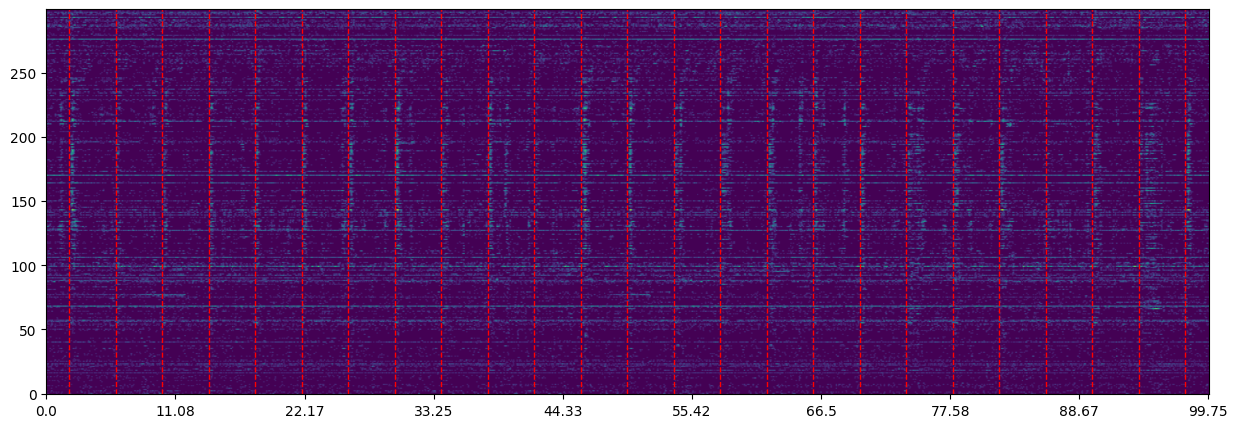

In [11]:
fig, axes = plt.subplots(1, figsize=(15, 5), sharey=True)

# axes.imshow(rates.T, aspect="auto")
area="Dls"
plot_heatmap_raster(pyal.select_trials(df_, df_.trial_name == 'trial')[50:75], area=area,ax=axes, show=False, add_sol_onset=True)
plt.show()

# rates.shape

### Decoding

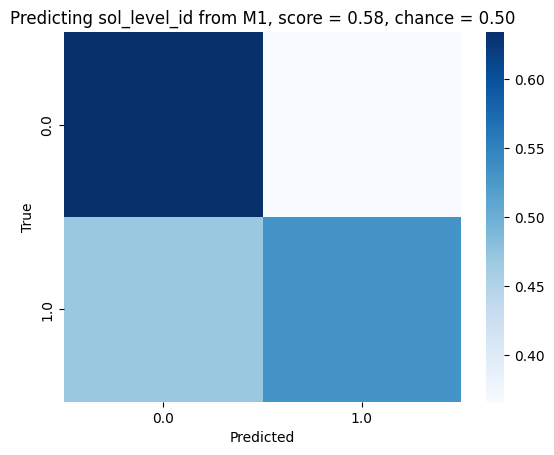

In [75]:
perturb_epoch = pyal.generate_epoch_fun(
        start_point_name="idx_sol_on",
        rel_start=int(0 / Params.BIN_SIZE),
        rel_end=int(1 / Params.BIN_SIZE),
    )

df_trials = pyal.select_trials(df_, "trial_name == 'trial'")
df_trials = pyal.select_trials(df_trials, "idx_trial_end > 30365")  # Remove first 5 minutes because the switch was off
df_trials = pyal.restrict_to_interval(df_trials, epoch_fun=perturb_epoch)


fig, ax = plt.subplots()
within_results = decode.within_decoding(cat = "sol_level_id", ax = ax,  allDFs = [df_trials], area = "M1", n_components = 10, epoch = perturb_epoch, model = "pca")

In [151]:
area = 'M1'
n_components = 10

perturb_epoch = pyal.generate_epoch_fun(
        start_point_name="idx_sol_on",
        rel_start=int(-2 / Params.BIN_SIZE),
        rel_end=int(1 / Params.BIN_SIZE),
    )

df_trials = pyal.select_trials(df_, "trial_name == 'trial'")
df_trials = pyal.select_trials(df_trials, "idx_trial_end > 30365")  # Remove first 5 minutes because the switch was off
# df_trials = pyal.restrict_to_interval(df_trials, epoch_fun=perturb_epoch)



rates = np.concatenate(df_trials[area + "_rates"].values, axis=0)  # Shape: (239 trials, 15 timepoints, 87 units)

# Fit PCA model
rates_model = PCA(n_components=n_components, svd_solver="full").fit(rates)

# Apply PCA to the dataframe
df_trials = pyal.apply_dim_reduce_model(df_trials, rates_model, area + "_rates", "_pca")



In [152]:
df_trials_upper = pyal.select_trials(df_trials, df_trials['sol_level_id'] == 0)
df_trials_lower = pyal.select_trials(df_trials, df_trials['sol_level_id'] == 1)


In [153]:
latents_upper = pyal.get_sig_by_trial(df_trials_upper, "_pca")
latents_upper = np.mean(latents_upper, axis=2)[:, :n_components]  # Reduce to first 3 PCA components

latents_lower = pyal.get_sig_by_trial(df_trials_lower, "_pca")
latents_lower = np.mean(latents_lower, axis=2)[:, :n_components]  # Reduce to first 3 PCA components


In [154]:
latents_upper.shape

(133, 10)

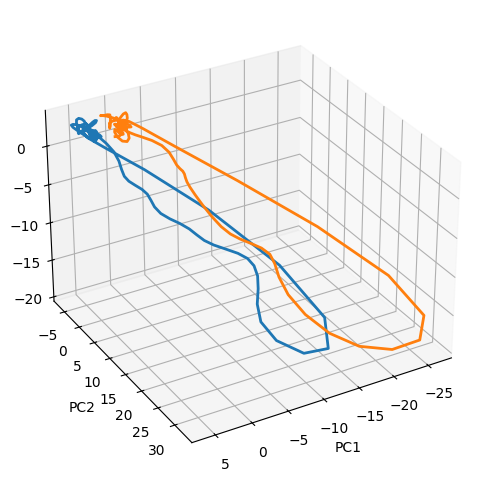

In [155]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': '3d'})

ax.plot(latents_upper[:, 0], latents_upper[:, 1], latents_upper[:, 2], linewidth=2)
ax.plot(latents_lower[:, 0], latents_lower[:, 1], latents_lower[:, 2], linewidth=2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.view_init(30, 60)


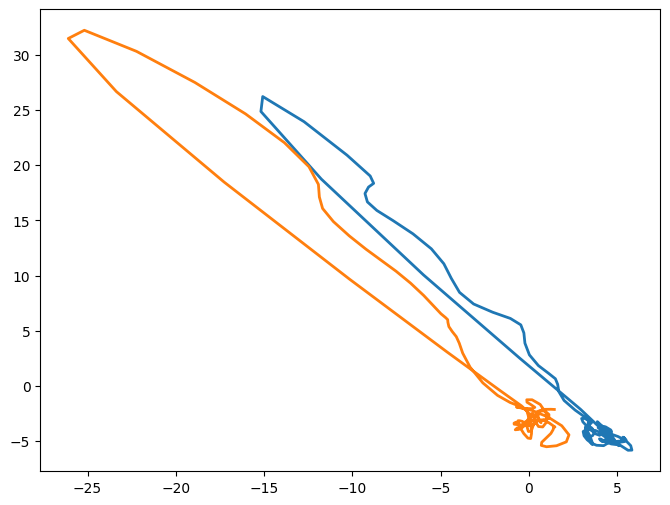

In [158]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(latents_upper[:, 0], latents_upper[:, 1], linewidth=2)
ax.plot(latents_lower[:, 0],  latents_lower[:, 1], linewidth=2)
# ax.view_init(60, 0)


In [147]:
from sklearn.metrics import confusion_matrix


AllData = get_data_array(
    [df_trials],
    "sol_level_id",
    area='M1',
    model='pca',
    n_components=10,
)

AllData = AllData[0, ...]
n_targets, n_trial, n_time, n_comp = AllData.shape

# print(AllData.shape)
# resizing

target_ids = np.unique(df_trials["sol_level_id"])

X = np.squeeze(AllData.reshape((-1, n_time* n_comp)))
AllTar = np.repeat(target_ids, n_trial)
AllTar = np.array(AllTar, dtype=int).flatten()

y_pred = cross_val_predict(GaussianNB(), X, AllTar, cv=5)
conf_mat = confusion_matrix(AllTar, y_pred, labels=target_ids)



In [148]:
conf_mat

array([[129,  95],
       [120, 104]])